## Siamese Network for House Recommendation [Demo]

**Goal**:<br>
build `siamese network`, `triplet loss`,`contrastive loss` to compare house feature embeddings and provide recommendations. <br>
**Note**: All helper functions are saved in `util.py`
<br>

**Reference**:<br>
[Siamese Network Keras for Image and Text similarity](https://medium.com/@prabhnoor0212/siamese-network-keras-31a3a8f37d04)<br>
[Home Embeddings for Similar Home Recommendations](https://www.zillow.com/tech/embedding-similar-home-recommendation/)

### STEP 0. Load in packages

**Need to cd in the DIR of this ipynb.**

In [ ]:
!pip install shap

In [2]:
from util import *

pd.set_option('display.max_columns', 999)

### Step 1: Prepare Data

In [3]:
data_src = "w_image" #"window_full"

anchor, positive, negative, y_train = load_dataset(data_src="w_image")
anchor_train, pos_train, neg_train, y_training, anchor_test, pos_test, neg_test, y_test = train_test_split(anchor, positive, negative, y_train, train_pct=0.9)

Loading data:
Anchor:  (81584, 84)
Positive:  (81584, 84)
Negative:  (81584, 84)
(81584, 84)
(73425, 84)
(8159, 84)


### Step 2: Build Model

#### 2.1 Contrastive Loss

In [14]:
## form pairs for contrastive loss model 
pair_input1 = np.concatenate((anchor_train,anchor_train))
pair_input2 = np.concatenate((pos_train, neg_train))

class0=np.zeros((anchor_train.shape[0],1))
class1=np.ones((anchor_train.shape[0],1))
output = np.concatenate((class1, class0))

pair_input1_val = np.concatenate((anchor_test,anchor_test))
pair_input2_val = np.concatenate((pos_test, neg_test))

class0_val=np.zeros((anchor_test.shape[0],1))
class1_val=np.ones((anchor_test.shape[0],1))
output_val = np.concatenate((class1_val, class0_val))

pair_input1.shape, pair_input2.shape

((146850, 84), (146850, 84))

In [17]:
# create siamese model using contrastive loss
input_shape = (anchor.shape[1],)
contrastive_model_embedding = create_embedding_model(input_shape)
siamese_model = build_contrastive_loss_model(input_shape, contrastive_model_embedding)
# Training the model
training_results =  siamese_model.fit(x=(pair_input1,pair_input2),y=output, 
                              validation_data=((pair_input1_val,pair_input2_val), output_val), 
                              batch_size=256, epochs=5)

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target (InputLayer)             [(None, 84)]         0                                            
__________________________________________________________________________________________________
candidate (InputLayer)          [(None, 84)]         0                                            
__________________________________________________________________________________________________
functional_13 (Functional)      (None, 16)           3376        target[0][0]                     
                                                                 candidate[0][0]                  
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           functional_13[0][0]  

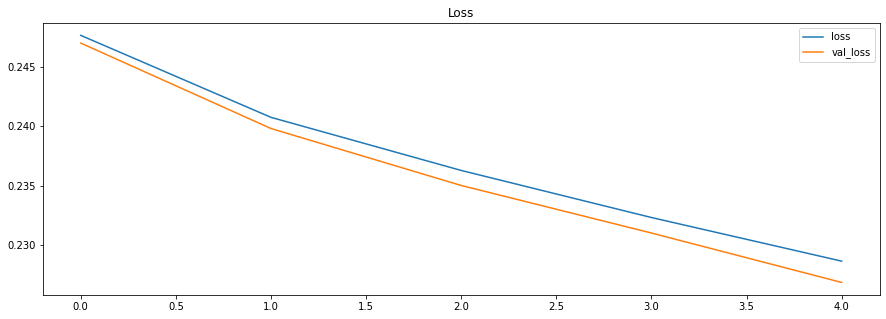

4590/4590 [==============================] - 5s 1ms/step - loss: 0.0000e+00
Evaluation Results: 0.0
Positive is higher than negative: 77.66999999999999 %


In [18]:
# plot model loss function
evaluate_model(siamese_model,(pair_input1,pair_input2), training_results)
# calculate if positive listing has higher score than negative listing
eval_pos_is_high(contrastive_model_embedding, anchor_test, pos_test, neg_test)

In [19]:
# save_model
# contrastive_model_embedding.save('save_model/contrastive_model_embedding_w_image') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save_model/contrastive_model_embedding_w_image/assets


#### 2.2 Triplet Loss

In [4]:
input_shape = (anchor.shape[1],)
triplet_model_embedding = create_embedding_model(input_shape)


siamese_model = build_triplet_model(input_shape, triplet_model_embedding)
training_results = siamese_model.fit(x=(anchor_train,pos_train,neg_train),y=y_training, 
                                     validation_data=((anchor_test,pos_test,neg_test), y_test), 
                                     batch_size=128, epochs=5)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 84)]         0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 84)]         0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 84)]         0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 16)           3376        positive[0][0]                   
                                                                 negative[0][0]        

None

Epoch 1/5
574/574 [==============================] - 1s 2ms/step - loss: 0.4566 - val_loss: 0.7837
Epoch 2/5
574/574 [==============================] - 1s 2ms/step - loss: 0.1296 - val_loss: 0.2134
Epoch 3/5
574/574 [==============================] - 1s 2ms/step - loss: 0.0728 - val_loss: 0.1981
Epoch 4/5
574/574 [==============================] - 1s 2ms/step - loss: 0.0698 - val_loss: 0.2330
Epoch 5/5
574/574 [==============================] - 1s 2ms/step - loss: 0.0674 - val_loss: 0.2148


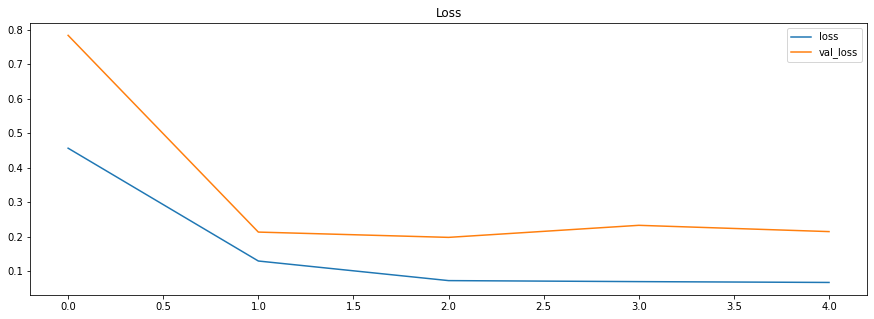

255/255 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Evaluation Results: 0.0
Positive is higher than negative: 81.35 %


In [5]:
evaluate_model(siamese_model,(anchor_test,pos_test,neg_test), training_results)
eval_pos_is_high(triplet_model_embedding, anchor_test, pos_test, neg_test)

In [12]:
#triplet_model_embedding.save('save_model/triplet_model_embedding_w_image') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save_model/triplet_model_embedding_w_image/assets


In [6]:
## cos similarity 
pos_scores = cosine_similarity(anchor_test, pos_test)
pos_scores = np.diag(pos_scores)

neg_scores = cosine_similarity(anchor_test, neg_test)
neg_scores = np.diag(neg_scores)

pos_is_high_sum = sum(pos_scores>neg_scores)
score = round(pos_is_high_sum/len(anchor_test)*100, 2)
print(f"Positive is higher than negative: {score} %")

Positive is higher than negative: 54.69 %


### Step 3: Interpretation

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.


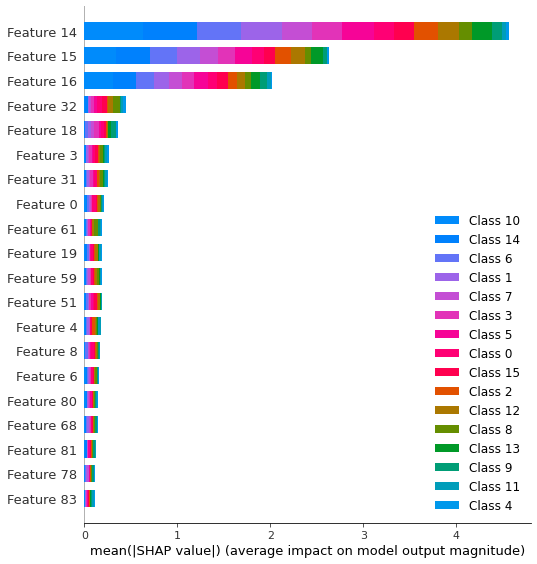

In [7]:
get_shap_interpretation(triplet_model_embedding, anchor, pick_k=300, max_display=20)

convert from feature # to  feature name

In [17]:
# house features
pkl_file = open('data/all_pairs_user_test_for_siamese_df.pkl', 'rb') # listing_dict
listing_df = pickle.load(pkl_file)
pkl_file.close()

print("Load in listing info: ", listing_df.shape)

feature_dim = anchor.shape[1]
wanted_cols = listing_df.columns.difference(['triple','rex_url'], sort=False)
valid_columns = listing_df[wanted_cols].iloc[:, :feature_dim].columns

Load in listing info:  (10600, 170)


In [18]:
id_ls = [14, 15,16, 18,59, 3,19,32,31,51,69,21,4,11,20,80,61,81,6,8]
top20 = valid_columns[id_ls]

for i, col in enumerate(top20):
    #print(id_ls[i], " ", col)
    print(col)

hotness_score_train
demand_score_train
supply_score_train
loc_tsne_1_train
1hot_fencing_description_Wrought Iron_train
has_jacuzzi_train
loc_tsne_2_train
1hot_pool_spa_types_Pool & Spa (both)_train
1hot_pool_spa_types_No_train
1hot_fencing_description_None_train
1hot_property_condition_Updated/Remodeled_train
1hot_marketing_budget_MEDIUM_train
has_pool_train
latitude_train
1hot_marketing_budget_LOW_train
indoor_dining_cluster_train
1hot_property_condition_Additions/Alterations_train
indoor_kitchen_cluster_train
has_garage_train
full_baths_train


### Step 4: Evaluation

Load in pre-trained model(s)

In [20]:
print("Load in pretrained models")
MODEL_NAME = "save_model/triplet_model_embedding_w_image"
triplet_model_embedding = tf.keras.models.load_model(MODEL_NAME)

Load in pretrained models


Load in true visiting history of each ip

In [11]:
# read python dict back from the file
# test house
pkl_file = open('data/ip_listing_temporal_test_full.pkl', 'rb')
user_listing_test = pickle.load(pkl_file)
print(user_listing_test.shape)
display(user_listing_test.head(2))
pkl_file.close()

(17102, 2)


,ip,rexUrl
11,1.129.109.119,22127-buena-ventura-st
65,1.65.170.128,6151-orange-st-apt-118


#### 4.1 Prepare evaluation data:

Load in all unseen pairs:
$$\{mean_{ip}, unseen\ listing\}$$
Calculate cos-similarit of embeddings

In [21]:
feature_dim = anchor.shape[1]

all_pairs_predictions = calculate_embedding_score(feature_dim, triplet_model_embedding,
                                                  data_src="w_image", row_size=15000,
                                                  is_cos=False)

0it [00:00, ?it/s]

Load in unseen pairs chunk by chunk: 


266it [05:25,  1.22s/it]


In [ ]:
# Save result "triplet" "contrastive", "contrastive2", "cos_sim", "triplet_img"
# all_pairs_predictions.to_pickle('./save_model/triplet2_img_all_pairs_predictions.pkl')

In [32]:
pkl_file = open('save_model/triplet_all_pairs_predictions.pkl', 'rb')
all_pairs_predictions = pickle.load(pkl_file)
pkl_file.close()

#### 4.2 Calculate

In [33]:
k_ls = [10, 20,30,50]

for k in k_ls:
  recommended_at_10, recall_at_10, precision_at_10 = precision_recall_at_k(all_pairs_predictions, 
                                                                           user_listing_test, k)
  print(f'precision @ {k}', np.mean(list(precision_at_10.values())))
  print(f'recall @ {k}', np.mean(list(recall_at_10.values())))
  print("\n")

precision @ 10 0.010354380699526721
recall @ 10 0.05935630959327139


precision @ 20 0.00926353457231906
recall @ 20 0.10182021023584117


precision @ 30 0.008565162184000923
recall @ 30 0.1387345180710022


precision @ 50 0.007593212512986264
recall @ 50 0.20388790514104976




#### 4.3 Case study

In [13]:
case_ip = "100.1.133.99" #"104.173.194.23" #"104.1.138.21" #
ip_candidate_df = all_pairs_predictions.loc[all_pairs_predictions.ip==case_ip]
ip_candidate_df.reset_index(drop=True, inplace=True)
print("Top 3 recommendation")
display(ip_candidate_df.head(3))
print("Actual Visit")
display(user_listing_test.loc[user_listing_test.ip==case_ip])

Top 3 recommendation


,ip,rex_url,proba,pred
0,100.1.133.99,5701-lunada-ln,0.997961,1.0
1,100.1.133.99,814-e-graves-ave,0.997670,1.0
2,100.1.133.99,8159-aldea-ave,0.997248,1.0


Actual Visit


,ip,rexUrl
86,100.1.133.99,8719-topanga-canyon-blvd


In [14]:
train_la = pd.read_pickle("./data/ip_listing_temporal_train_full.pkl")
listing_data = pd.read_pickle('./data/LOG_siamese_data_11_12.pkl')


iptest = case_ip
training_case = train_la[train_la.ip==iptest].merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
training_case['sqft'] = np.exp(training_case['log_sqft']).map('{:,.0f}'.format)
training_case['price'] = np.exp(training_case['log_price']).map('{:,.0f}'.format)
training_case['total_rooms'] = np.exp(training_case['log_total_rooms'])
cols = ['rex_url','sqft','price','bedrooms','total_rooms','full_baths','is_apt']

training_case[cols]

,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,5418-geyser-ave,"1,313","799,000",3.0,6.0,2.0,0.0
1,1415-n-myers-st,"1,782","840,000",5.0,5.0,3.0,0.0
2,8450-denise-ln,"1,776","660,000",3.0,7.0,2.0,0.0
3,9323-alcott-st-apt-101,"2,588","1,329,999",5.0,17.0,5.0,1.0


In [15]:
test_la = pd.read_pickle("./data/ip_listing_temporal_test_full.pkl")

testing_case = test_la[test_la.ip==iptest].merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
testing_case['sqft'] = np.exp(testing_case['log_sqft']).map('{:,.0f}'.format)
testing_case['price'] = np.exp(testing_case['log_price']).map('{:,.0f}'.format)
testing_case['total_rooms'] = np.exp(testing_case['log_total_rooms'])

testing_case[cols]

,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,8719-topanga-canyon-blvd,"2,144","719,000",4.0,8.0,3.0,0.0


In [16]:
ip_candidate_df.loc[ip_candidate_df.rex_url.isin(["8719-topanga-canyon-blvd"])]

,ip,rex_url,proba,pred
8,100.1.133.99,8719-topanga-canyon-blvd,0.99626,1.0
